# Análise de Viés de Gênero em Biografias da Wikipédia em Português


# 1. Introdução

O objetivo deste trabalho foi investigar a existência de viés de gênero especificamente em biografias disponíveis na Wikipédia em português.  A análise foi construída a partir de uma comparação de como homens e mulheres são apresentados nas biografias. É importante ressaltar que uma limitação desse trabalho é que foi considerado apenas dois gêneros: masculino e feminino.

Existem alguns estudos sobre viés na Wikipédia em inglês, que analisam as propriedades da linguagem utilizada, metadados e links entre as biografias. Também existem estudos para tentar identificar viés de gênero em word embeddings, usando analogias com profissões que são majoritariamente ocupadas por homens e outras por mulheres para tentar identificar associações. Baseado nesses estudos construi uma análise para a Wikipédia em português.

## 1.1 Motivação

A wikipédia provê uma plataforma para compartilhamento gratuito de conhecimento entre as pessoas, em que qualquer pessoa pode contribuir para seu conteúdo.

Entretanto, em 2012 uma pesquisa sobre os contribuidores da Wikipédia concluiu que menos de 15% dos editores são mulheres. Essa disparidade foi chamada de gender gap, e motivou diferentes estudos para entender esse fenômeno social. E essa diversidade limitada da comunidade de voluntários da Wikipédia têm potencial para introduzir vieses no conteúdo dessa enciclopédia. 

In [1]:
## imports necessários
import pandas as pd
import nltk
import json
import os
import numpy as np
from string import punctuation
import re
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gensim
import math
import random

from nltk.corpus import floresta

from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import KFold

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import gender_guesser.detector as gender
from IPython.display import display

# 2. Metodologia e Resultados

A metodologia utilizada consiste basicamente de 4 passos principais:
1. A coleta e pré-processamento dos dados;
2. Inferência do gênero das pessoas descritas nas biografias: Isso é necessário pois essa informação não é disponibilizada na Wikipédia;
3. Análise da linguagem utilizada nas biografias;
4. Treinamento de modelos Word2Vec no corpus coletado e avaliação através de analogias contendo profissões que são consideradas mais relacionadas a um gênero. 

## 2.1. Coleta e Pré-Processamento dos Dados

O primeiro passo da metodologia foi a coleta dos dados. Isso foi feito a partir da plataforma Wikimedia que é atualizada mensalmente com todos os artigos da wikipédia. Tendo coletado os artigos da Wikipédia em Português foi necessário um processo de extração dos textos que representam biografias bem como um pré-processamento desses textos que foram coletados em XML e contém diversas tags, porém estamos interessados apenas no texto em si. Para extrair e limpar o texto foi utilizada a ferramenta WikiExtractor (https://github.com/attardi/wikiextractor). Não entrarei em muitos detalhes desse processo, mas ao final foram extraídas cerca de 26 mil biografias. Os dados pré-processados estão disponíveis na pasta `biographies`.

### 2.1.1 Pré-processamento dos textos para as análises

Abaixo temos algumas funções auxiliares usadas no decorrer do projeto para pré-processar o texto (tirar pontuações e números), extrair apenas os dois primeiros parágrafos, tokenizar, remover stopwords e funções para computar o document frequency, term frequency e o TF-IDF.


In [2]:
def preprocess(data):
    data = data.lower()
    data = data.replace("''", "")
    data = data.replace('"', '')
    data = data.replace('.', ' ')
    data = data.replace('—', ' ')
    data = data.replace('  ', ' ')
    data = re.sub(r'\d+', '', data)  # remove numeros 
    return data

def two_pharagraph(data):
    text = data.split('\n')
    final = ""
    if len(text) > 1:
        final = text[0]+text[1]
        if text[0] == ' ' and len(text) > 2:
            final += text[2]
    else:
        final = text[0]
    return final

def tokenize(text, remove_stopwords=True):
    tokens = text.split()
    if remove_stopwords:
        tokens = [token.strip(punctuation) for token in tokens if token not in list(punctuation)+stopwords+meses]
    else:
        tokens = [token.strip(punctuation) for token in tokens if token not in list(punctuation)+meses]
    tokens = [token for token in tokens if len(token) >= 1]
    return tokens

def stemmer(tokens):
    ptStemmer = SnowballStemmer("portuguese", ignore_stopwords=True)
    return [ptStemmer.stem(token) for token in tokens]

def document_list(preprocessed_text):
    DF = {}
    # list of documents that the word appears
    for i in range(len(preprocessed_text)):
        tokens = preprocessed_text[i]
        for w in tokens:
            try:
                DF[w].add(i)
            except:
                DF[w] = {i}
    return DF

def document_frequency(preprocessed_text):
    DF = document_list(preprocessed_text)
    # number of occurences = document frequency
    for i in DF:
        DF[i] = len(DF[i])
    return DF

def term_frequency(preprocessed_text):
    tf = {}
    N = len(preprocessed_text)
    for i in range(N):
        tokens = preprocessed_text[i]
        counter = Counter(tokens)
        for token in np.unique(tokens):
            try:
                tf[token] += counter[token]/len(tokens)
            except:
                tf[token] = counter[token]/len(tokens)
    return tf

def calculate_tf_idf(preprocessed_text):
    DF = document_frequency(preprocessed_text)
    tf_idf = {}
    N = len(preprocessed_text)
    for i in range(N):
        tokens = preprocessed_text[i]
        counter = Counter(tokens)
        for token in np.unique(tokens):
            tf = counter[token]/len(tokens)
            df = DF[token]
            idf = np.log(N/(df+1))
            tf_idf[i, token] = tf*idf
    return tf_idf

Abaixo passamos por todas as biografias, salvamos o texto com um primeiro pré-processamento, e criamos um dicionário auxiliar que contém o nome, id e gênero. O gênero é preenchido como `unknown` pois a seguir será feito um processo de inferência de gênero para descobrir o gênero de cada pessoa descrita na Wikiédia.

In [3]:
dataset = []
names = []
all_text = []
for file in os.listdir("./biographies"):
    with open("./biographies/"+file) as json_file:
        data = json.load(json_file)
        names_dict = {}
        if 'Mortes' in data['title']:
            continue
        names_dict['name'] = data["title"]
        names_dict['id'] = data['id']
        names_dict['gender'] = 'unknown'
        data = preprocess(data['text'])
        names.append(names_dict)
        dataset.append(two_pharagraph(data))
        all_text.append(data)

Abaixo temos um segundo pré-processamento de cada biografia no qual formamos dois conjuntos pré-processados um sem stopwords e outro com, pois as stopwords serão necessárias em uma abordagem de inferência de gênero. Decidi tirar também as palavras que representam nomes de meses visto que os números foram removidos essas palavras não representam muito sentido mais. 

In [4]:
meses = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro',
        'novembro', 'dezembro']
stopwords = nltk.corpus.stopwords.words('portuguese')
preprocessed_text = []
texts = []
for i in range(0, len(dataset)):
    preprocessed_text.append(tokenize(dataset[i], remove_stopwords=True))
    texts.append(tokenize(dataset[i], remove_stopwords=False))
print(preprocessed_text[0])

['bernardo', 'cesar', 'carlos', 'belarmino', 'amorim', 'mossoró', 'médico', 'político', 'brasileiro', 'biografias']


## 2.2. Inferência de Gênero

Baseado na tarefa de Coreference Resolution tive a ideia de utilizar POS Tagging para encontrar pronomes pessoais, artigos seguidos de adjetivos entre outras formações gramaticais que pudessem ajudar a inferir o gênero da pessoa a qual o texto se refere. 

Então, antes de mostrar o código para a abordagem com o POS Tagging foi feito também um baseline para podermos saber se a abordagem com POS Tagging gera resultados similares. Como a tarefa é não supervisionada, não é possível assumir que o baseline ou a abordagem de POS Tagging serão sempre certos mas é importante analisar se elas ao menos convergem para a mesma predição na maioria dos dados.

### 2.2.1. Inferência de Gênero - Baseline

O baseline criado foi feito em duas etapas:

1. Uso de uma base de nomes auxiliar para infererir o gênero de uma pessoa a partir do nome. Foi utilizada a base do ibge para inferir nomes de biografias que se referem a pessoal do Brasil ou Portugal. Utilizamos também uma base que já contém o gênero inferido para algumas biografias da Wikipedia em inglês. E além disso, utilizamos a biblioteca gender_guesser para inferir nomes de americanos.

2. Após possuir o gênero inferido para parte do dataset, isso foi utilizado como treino para algoritmos de aprendizado supervisionado para tentar inferir o gênero das pessoas utilizando apenas os dois primeiros parágrafos das biografias (que acredito que já possui informação suficiente para tal).

### Montagem do Dicionário de Nomes

In [5]:
df_names = pd.read_csv("names.csv", sep='\t') 
df_names.head()

,id,gender,name
0,307,MALE,Abraham Lincoln
1,339,FEMALE,Ayn Rand
2,340,MALE,Alain Connes
3,344,MALE,Allan Dwan
4,595,MALE,Andre Agassi


In [6]:
# preenchendo com base de nomes ja criada sobre a wikipedia
for i in range(len(names)):
    if names[i]['name'] in df_names['name'].tolist():
        indx = df_names['name'].tolist().index(names[i]['name'])
        names[i]['gender'] = df_names['gender'].iloc[indx].lower()

In [7]:
df_pt_names = pd.read_csv("nomes.csv", sep=",")
df_pt_names.head()

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0


In [8]:
# preenchendo com base do ibge 
from unidecode import unidecode
def get_gender(nome_completo, i):
    primeiro_nome = unidecode(nome_completo.split(" ")[0])
    if primeiro_nome.upper() in df_pt_names['first_name'].tolist():
        indx = df_pt_names['first_name'].tolist().index(primeiro_nome.upper())
        if df_pt_names['classification'].iloc[indx] == 'F':
            names[i]['gender'] = 'female'
        else:
            names[i]['gender'] = 'male'

for i in range(len(names)):
    if names[i]['gender'] == 'unknown':
        if re.search(r'brasil', dataset[i]):
            get_gender(names[i]['name'], i)
        elif re.search(r'portug', dataset[i]):
            get_gender(names[i]['name'], i)

In [9]:
import gender_guesser.detector as gender
# avalia nomes americanos com o gender_guesser detector
d = gender.Detector()
for i in range(len(names)):
    if names[i]['gender'] == 'unknown':
        matchObj = re.search(r'america', dataset[i])
        if matchObj:
            det = d.get_gender(names[i]['name'].split(" ")[0])
            if det == 'male' or det == 'female':
                names[i]['gender'] = det

In [10]:
data_gender = []
label_gender = []
for i in range(len(names)):
    if names[i]['gender'] != 'unknown':
        data_gender.append(preprocessed_text[i])
        label_gender.append(names[i]['gender'])

data_unknown = []
for i in range(len(names)):
    if names[i]['gender'] == 'unknown':
        data_unknown.append(preprocessed_text[i])

In [11]:
def coverage():
    count = 0
    for i in range(len(names)):
        if names[i]['gender'] != 'unknown':
            count+=1
    return count

### Montagem do conjunto de treino e teste

Após possuir o gênero de parte do dataset, foi montado um dataframe com as features sendo as palavras utilizadas em cada texto. Para tal, foi calculado o term frequency e as palavras com term frequency menores que 3 foram excluídas.

In [12]:
df_list_gender = document_list(data_gender)
df_list_unknown = document_list(data_unknown)
tf_gender = term_frequency(data_gender)
tf_dict = {k: v for k, v in sorted(tf_gender.items(), key=lambda item: item[1], reverse=True)}
tf_dict = {k: v for k, v in tf_dict.items() if v >= 3}
features = [k for k, v in tf_dict.items()]

data_tf = np.zeros((coverage(), len(tf_dict)))
data_unknown_tf = np.zeros((len(dataset)-coverage(), len(tf_dict)))

## criamos um dataframe em que a coluna vai ter valor 1 se a palavra estiver na biografia e 0 caso contrário
for j in range(len(features)):
    for i in iter(df_list_gender[features[j]]):
        data_tf[i, j] = 1
        
for j in range(len(features)):
    for i in iter(df_list_unknown[features[j]]):
        data_unknown_tf[i, j] = 1


data_tf = pd.DataFrame(data_tf, columns = features)
data_unknown_tf = pd.DataFrame(data_unknown_tf, columns = features)
data_tf.head()

,brasileiro,biografia,carreira,conhecido,rio,político,atualmente,janeiro,paulo,brasileira,...,ocupou,fundadores,candidato,catarina,democracia,ensaísta,luta,ciência,trabalhista,conceição
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Imprime a porcentagem de false positive e confirmed
display((pd.Series(label_gender).value_counts()/len(label_gender)*100).round(2).to_frame('GENDER' +" (%)").T)

# Criação de labels binários
label_gender = [0 if i != "female" else 1 for i in label_gender]

,male,female
GENDER (%),78.26,21.74


In [14]:
def plot_curva(x, y1, y2, x_label, y_label):
    plt.figure(figsize=(8, 5))
    plt.plot(x, y1, label= "Training")
    plt.plot(x, y2, label= "Validation")
    # distinção para plotar gráfico da decision tree no ponto em que temos altura ilimitada
    if x_label == "max_depth":
        trainAcc, valAcc ,_,_,_,_= decision_tree(None) 
        plt.plot([20], [trainAcc], 'ro',  ms=15, label = 'No depth limit training(y-axis only)')
        plt.plot([20], [valAcc], 'bo', ms=15, label = 'No depth limit 5-fold validation(y-axis only)')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

### Uso de classificador para inferir o gênero do restante da base

Foram testados alguns classificadores diferentes como XGB, SVM, DecisionTree, RandomForest e LogisticRegression. Mas o classificador que obteve melhores resultados foi o Random Forest, dessa forma nesse notebook, que é apenas um sumário das tentativas realizadas, deixei apenas o melhor classificador.

In [15]:
def random_forest(N, X, y):
    train_score = []
    val_score = []
    y_probab = []
    f1_score = []
    recall_score = []
    precision_score = []
        
    for train, val in kf.split(X, y):

        classifier = ensemble.RandomForestClassifier(n_estimators=N)
        classifier = classifier.fit(X[train], y[train])

        train_score.append(classifier.score(X[train], y[train]))
        val_score.append(classifier.score(X[val], y[val]))

        y_pred = classifier.predict(X[val])
        f1_score.append(metrics.f1_score(y[val], y_pred))
        recall_score.append(metrics.recall_score(y[val], y_pred))
        precision_score.append(metrics.precision_score(y[val], y_pred))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    recall = np.mean(recall_score)
    f1 = np.mean(f1_score)
    precision = np.mean(precision_score)
    
    return trainAcc, valAcc, recall, f1, precision, y_probab

Foi utilizado o algoritmo de ganho de informação para escolher quais as palavras mais importantes para a predição. Esse algoritmo foi executado em cima do conjunto de treino montado anteriormente a partir da frequência dos termos no documento. Depois disso, foi feito um guloso aumentando o número de palavras utilizadas para a predição de 25 a 50 palavras.

In [16]:
X = data_tf.values
y = pd.Series(label_gender).values  

res = dict(zip(data_tf.columns,
               mutual_info_classif(X, y, discrete_features=True)
               ))
ig_dict = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

features = [k for k, v in ig_dict.items()]
features

['brasileiro',
 'atriz',
 'brasileira',
 'conhecida',
 'conhecido',
 'cantora',
 'político',
 'norte-americana',
 'escritora',
 'nascida',
 'professora',
 'compositora',
 'portuguesa',
 'maria',
 'mulher',
 'futebolista',
 'apresentadora',
 'português',
 'filiada',
 'norte-americano',
 'ator',
 'deputada',
 'professor',
 'eleita',
 'filha',
 'considerada',
 'filiado',
 'deputado',
 'ex-futebolista',
 'feminino',
 'advogado',
 'política',
 'americana',
 'eleito',
 'modelo',
 'atuava',
 'nascido',
 'atualmente',
 'produtora',
 'considerado',
 'escritor',
 'mulheres',
 'filho',
 'primeira',
 'atua',
 'compositor',
 'actriz',
 'empresário',
 'ana',
 'joga',
 'josé',
 'zagueiro',
 'americano',
 'engenheiro',
 'pornográfica',
 'atacante',
 'ministro',
 'volante',
 'jogador',
 'prefeito',
 'diretor',
 'autor',
 'mãe',
 'governador',
 'cantor',
 'militar',
 'secretário',
 'produtor',
 'antônio',
 'joão',
 'médico',
 'músico',
 'televisão',
 'filósofo',
 'campeão',
 'manuel',
 'pessoal',
 'trei

Number of features: 25


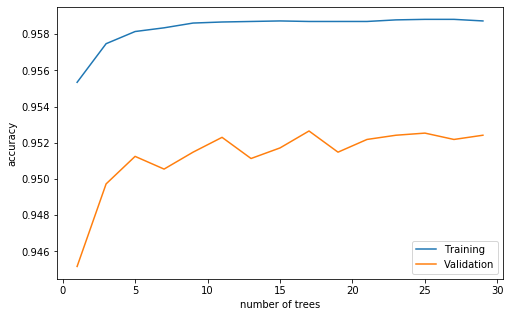

Number of features: 30


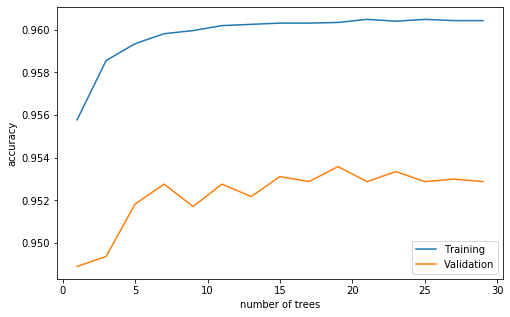

Number of features: 35


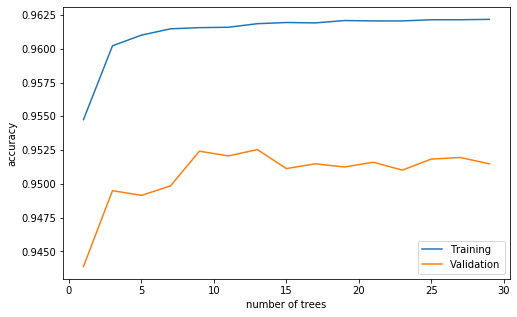

Number of features: 40


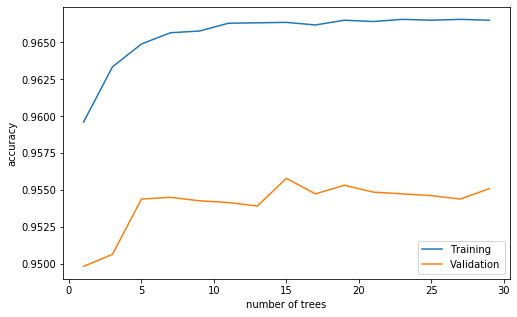

Number of features: 45


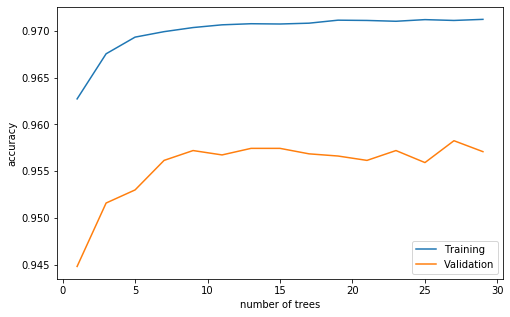

Number of features: 50


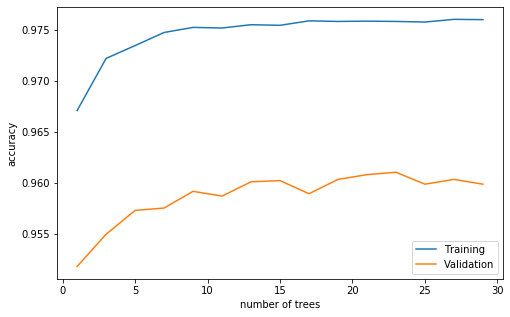

In [17]:
X = data_tf.values
y = pd.Series(label_gender).values  

res = dict(zip(data_tf.columns,
               mutual_info_classif(X, y, discrete_features=True)
               ))
ig_dict = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

features = [k for k, v in ig_dict.items()]

for x in range(25, 55, 5): 
    features_ = features[:x]

    data_ig = np.zeros((coverage(), len(features_)))
    data_unknown_ig = np.zeros((len(dataset)-coverage(), len(features_)))

    for j in range(len(features_)):
        for i in iter(df_list_gender[features_[j]]):
            data_ig[i, j] = 1

    for j in range(len(features_)):
        for i in iter(df_list_unknown[features_[j]]):
            data_unknown_ig[i, j] = 1

    data_ig = pd.DataFrame(data_ig, columns = features_)
    data_unknown_ig = pd.DataFrame(data_unknown_ig, columns = features_)
    
    X = data_ig.values 
    y = pd.Series(label_gender).values  

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


    kf = KFold(n_splits = 5)

    print("Number of features: {}".format(x))

    acc_modelTrain = []
    acc_modelVal = []
    n_trees = list(range(1,31,2)) #Valores do número de árvores a ser variado
    for i in n_trees:
        trainAcc, valAcc ,_,_,_,_ = random_forest(i, X_train, y_train)    
        acc_modelTrain.append(trainAcc)
        acc_modelVal.append(valAcc)
    plot_curva(n_trees, acc_modelTrain, acc_modelVal, "number of trees", "accuracy")

O melhor modelo encontrado foi usando 18 estimadores e 50 palavras.

In [18]:
trainAcc, valAcc, recall, f1, precision, predictions = random_forest(18, X_train, y_train)
print("Acuracia de treino do melhor modelo: {:.3}".format(trainAcc))
print("Acuracia de validação do melhor modelo: {:.3}".format(valAcc))
print("Recall: {:.3}".format(recall))
print("F1 score: {:.3}".format(f1))
print("Precision: {:.3}".format(precision))

classifier = ensemble.RandomForestClassifier(n_estimators=18)
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print("\nAcuracia de teste {}".format(classifier.score(X_test, y_test)))

Acuracia de treino do melhor modelo: 0.976
Acuracia de validação do melhor modelo: 0.961
Recall: 0.904
F1 score: 0.909
Precision: 0.915

Acuracia de teste 0.9660654959658282


Aqui foi plotada também uma matriz de confusão e podemos ver que o modelo acerta muito bem.

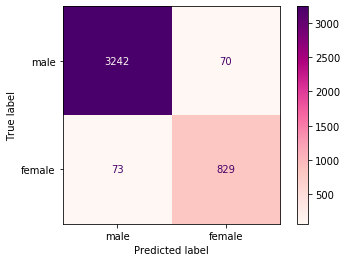

In [19]:
metrics.plot_confusion_matrix(classifier, X_test, y_test, display_labels=['male','female'], cmap=plt.cm.RdPu, normalize=None)  
plt.show()

In [20]:
# analise de feature importance
fi = pd.DataFrame({'feature': list(data_ig.columns),
                   'importance': classifier.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head(10)

,feature,importance
1,atriz,0.122408
2,brasileira,0.109496
3,conhecida,0.108909
0,brasileiro,0.081917
7,norte-americana,0.052602
5,cantora,0.048825
8,escritora,0.046839
12,portuguesa,0.040509
9,nascida,0.037822
4,conhecido,0.037235


Então, o modelo foi usado para prever as labels para o restante das biografias que não foram rotuladas com o dicionário de nomes.

In [21]:
classifier = ensemble.RandomForestClassifier(n_estimators=18)
classifier = classifier.fit(X, y)
y_pred = classifier.predict(data_unknown_ig.values)

In [22]:
count_male = 0
count_female = 0
j = 0
for i in range(len(names)):
    if names[i]['gender'] == 'unknown':
        if y_pred[j] == 0:
            names[i]['gender'] = 'male'
            count_male += 1
        else:
            names[i]['gender'] = 'female'
            count_female += 1
        j += 1

Salva um dicionário contendo o id e gênero do baseline.

In [23]:
id_gender = {}
for i in range(len(names)):
    id_gender[names[i]['id']] = names[i]['gender']

### 2.2.2. Inferência de Gênero - Abordagem com POS Tagging

Foi utilizado o corpus Floresta do NLTK que contém textos escritos em português de Portugal e do Brasil. E isso é interessante pois na base de biografias também existem textos em português de Portugal.

Abaixo temos o modelo de POS Tagging usado. Foi usada uma combinação dos taggers Default, Unigram e Bigram disponíveis no NLTK. Os taggers Default e Unigram são especificados como "backoff". Dessa forma, o DefaultTagger atua com o papel de dar uma tag default para quando as palavras não estão no vocabulário do corpus de treinamento. Além disso, se o BigramTagger atribuir a mesma tag que seu unigram backoff tagger em um determinado contexto, o bigram tagger descarta a instância de treinamento. Isso mantém o modelo do tagger bigrama o menor possível.

(Abaixo será usado o corpus das biografias COM stopwords. E continuamos usando apenas os dois primeiros parâgrafos das biografias.)

In [24]:
def simplify_tag(t):
    if "+" in t:
        return t[t.index("+")+1:]
    else:
        return t
    
tsents = floresta.tagged_sents()
train = [[(w.lower(),simplify_tag(t)) for (w,t) in sent] for sent in tsents if sent]
tagger0 = nltk.DefaultTagger('n')
tagger_uni = nltk.UnigramTagger(train, backoff=tagger0)
tagger_bi = nltk.BigramTagger(train, backoff=tagger_uni)

tags = []
for s in texts:
    tags.append([tag for word, tag in tagger_bi.tag(s)])

Foi definida uma estratégia heurística para extrair o gênero a partir das tags. Foram identificadas algumas formações gramaticais que comumente aparecem ao se descrever uma pessoa, e foi então tentado extrair o gênero das palavras pertencentes a essas formações. É uma forma também de tirarmos proveito da lígua portuguesa ser uma língua que possui gênero em muitas palavras.

In [25]:

def gender_by_grammar_analysis(text, tags):
    points_men = 0
    points_women = 0
    first_description = 1
    
    for i, tag in enumerate(tags):
        visited = [0 for i in range(len(text))]
        if tag == 'pron-pers':
            if text[i] == 'ele' or text[i] == 'dele':
                points_men +=1
            if text[i] == 'ela' or text[i] == 'dela':
                points_women +=1
                
        if tag == 'art' and i < len(tags)-2:
            if tags[i+1] == 'n' and (tags[i+2] == 'adj' or tags[i+2] == 'n' or tags[i+2] == 'v-pcp'):
                if text[i] == 'uma':
                    if text[i+2][-1:] == 'a':
                        points_women += 2
                        visited[i+2] = 1
                    else:
                        points_women +=1
                if text[i] == 'um':
                    if text[i+2][-1:] == 'o':
                        points_men += 2
                        visited[i+2] = 1
                    else:
                        points_men +=1
                        
        if (text[i] == 'é' or text[i] == 'era' or text[i] == 'foi') and i < len(tags)-2 and first_description:
            if tags[i+1] == 'art' and (tags[i+2] == 'n' or tags[i+2] == 'adj' or tags[i+2] == 'v-pcp'):
                if text[i+1] == 'uma':
                    points_women += 2
                if text[i+1] == 'um':
                    points_men += 2
            first_description = 0
        
        if tags[i] == 'v-pcp':
            if text[i] == 'nascida' or text[i] == 'conhecida':
                points_women += 2
            if text[i] == 'nascido' or text[i] == 'conhecido':
                points_men += 2
                
        if tags[i] == 'n' or tags[i] == 'adj':
            if text[i][-1:] == 'a':
                points_women += 0.01
            if text[i][-1:] == 'o' or text[i][-2:] == 'or':
                points_men += 0.01
            
    if points_men >= points_women:
        return 'male'
    else:
        return 'female'

Captura o gênero através da estratégia heurística acima.

In [26]:
gender = []
for i, text in enumerate(texts):
    gender.append(gender_by_grammar_analysis(text, tags[i]))

In [27]:
count_men = 0
for g in gender:
    if g == 'male':
        count_men+=1
print(f'Número de Biografias sobre homens: {count_men}')
print(f'Número de Biografias sobre mulheres: {len(gender) - count_men}')

## preencher o dicionário com os nomes encontrados
for person, g in zip(names, gender):
    person['gender'] = g

Número de Biografias sobre homens: 20008
Número de Biografias sobre mulheres: 5723


Abaixo temos os casos em que a estratégia com classificação difere da abordagem com POS Tagging. Em particular, o que aparece no print é o resultado da solução com POS Tagging, então se aparece `female` no print quer dizer que a solução com o classificador fez a previsão de que a classe correta era `male`. É interessante observar que na maioria dos casos a label dada pela estratégia com POS Tagging parece condizente com o nome das pessoas.

In [28]:
## compara a estratégia com POS Tagging com a classificação
count=0
c = 0
for ml, pos in zip(id_gender.items(), names):
    if ml[1] != pos['gender']:
        print(pos)
        count+=1

{'name': 'Antonio Maria Valsalva', 'id': '1843558', 'gender': 'male'}
{'name': 'Andreea Ehritt-Vanc', 'id': '4774648', 'gender': 'female'}
{'name': 'Mariana de Jesús de Paredes', 'id': '6351714', 'gender': 'female'}
{'name': 'Simone Manuel', 'id': '5364122', 'gender': 'female'}
{'name': 'Salvador Barata Feyo', 'id': '217410', 'gender': 'female'}
{'name': 'Yukie Nakayama', 'id': '5164261', 'gender': 'female'}
{'name': 'Allen Collins', 'id': '2017710', 'gender': 'female'}
{'name': 'Betty Williams', 'id': '131373', 'gender': 'female'}
{'name': 'Soeiro Gomes', 'id': '159932', 'gender': 'male'}
{'name': "Anne de Pisseleu d'Heilly", 'id': '6366497', 'gender': 'female'}
{'name': 'Ellen Arthur', 'id': '2507420', 'gender': 'female'}
{'name': 'Katrin Siska', 'id': '1307592', 'gender': 'female'}
{'name': 'Bita', 'id': '2358278', 'gender': 'male'}
{'name': 'Stephanie Honoré', 'id': '5534439', 'gender': 'female'}
{'name': 'Creme Puff', 'id': '6321409', 'gender': 'female'}
{'name': 'Natasha Hansen',

In [31]:
print('As duas soluções concordaram {:.2f}% das vezes.'.format((len(names)-count)/len(names)*100))

As duas soluções concordaram 95.39% das vezes.


## 2.3. Análise das Propriedades da Linguagem 

Abaixo foi feito novamente um pré-processamento do texto mas aqui ao invés de usar os 2 primeiros parágrafos apenas, nós temos o texto todo. 

Nessa etapa também foi feita uma análise sobre as palavras mais frequentes e várias outras plotagens em nuvens de palavras para tentar identificar padrões e então chegar na análise final. Porém, novamente, como esse relatório é apenas um sumário, decidi deixar apenas os resultados mais relevantes.

In [33]:
meses = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro',
        'novembro', 'dezembro']
stopwords = nltk.corpus.stopwords.words('portuguese')
preprocessed_text = []
for i in range(0, len(all_text)):
    preprocessed_text.append(tokenize(all_text[i], remove_stopwords=True))
print(preprocessed_text[0])

['bernardo', 'cesar', 'carlos', 'belarmino', 'amorim', 'mossoró', 'médico', 'político', 'brasileiro', 'biografias', 'nasceu', 'mossoró', 'interior', 'rio', 'grande', 'norte', 'formou-se', 'medicina', 'universidade', 'federal', 'rio', 'grande', 'norte', 'após', 'graduação', 'especializou-se', 'gastroenterologia', 'faculdade', 'ipemed', 'ciências', 'médicas', 'bahia', 'filho', 'tradicional', 'político', 'almino', 'afonso', 'eleito', 'prefeito', 'almino', 'afonso', 'psd', 'votos', 'reeleito', 'cargo', 'pl', 'votos', 'eleito', 'deputado', 'estadual', 'rio', 'grande', 'norte', 'avante', 'votos']


### Pointwise Mutual Information

Foi utilizada a métrica Pointwise Mutual Information para descobrir quais palavras são mais associadas a cada gênero. Essa etapa teve 2 passos:

1. Dicionário de palavras comuns aos dois gêneros
2. Calculo do pmi para mulheres e homens em cima do dicionário comum aos dois gêneros

In [34]:
vocabulary_male = set()
vocabulary_female = set()
male_text = []
female_text = []
for i in range(len(preprocessed_text)):
    if (names[i]['gender'] == 'male'):
        male_text.append(preprocessed_text[i])
        for j in range(len(preprocessed_text[i])):
            vocabulary_male.add(preprocessed_text[i][j])
    if (names[i]['gender'] == 'female'):
        female_text.append(preprocessed_text[i])
        for j in range(len(preprocessed_text[i])):
            vocabulary_female.add(preprocessed_text[i][j])

In [35]:
common_words = list((vocabulary_male).intersection(vocabulary_female))
vocabulary_male -= set(common_words)
vocabulary_female -= set(common_words)

In [36]:
df_male = document_frequency(male_text)
df_female = document_frequency(female_text)
df_total = document_frequency(preprocessed_text)

Como o PMI dá mais peso a palavras com frequências menores, foi considerado apenas palavras que aparecem em pelo menos 1% das biografias de mulheres e homens.


In [37]:
prob_women = len(female_text)/len(preprocessed_text)
prob_men = len(male_text)/len(preprocessed_text)
pmi_women = {}

for i in common_words:
    if (df_total[i] > 0.01*len(preprocessed_text)):
        prob_word_women = df_female[i]/len(female_text) 
        prob_word = df_total[i]/len(preprocessed_text)
        pmi_women[i] = math.log(prob_word_women/(prob_women*prob_word))

pmi_men = {}

for i in common_words:
    if df_total[i] > 0.01*len(preprocessed_text):
        prob_word_men = df_male[i]/len(male_text) 
        prob_word = df_total[i]/len(preprocessed_text)
        pmi_men[i] = math.log(prob_word_men/(prob_men*prob_word))

In [38]:
{k: v for k, v in sorted(pmi_women.items(), key=lambda item: item[1], reverse=True)}

{'convidada': 2.9320084044449986,
 'sepultada': 2.915254524843197,
 'compositora': 2.8925397477632315,
 'feminista': 2.8755271199226287,
 'indicada': 2.865251376763676,
 'feminino': 2.8212857975386534,
 'eleita': 2.811815045113089,
 'autora': 2.8090472603403627,
 'feminina': 2.799206793581784,
 'contratada': 2.7961112856624974,
 'escritora': 2.792380207855151,
 'casada': 2.7878041824509046,
 'nascida': 2.7587023784420515,
 'escalada': 2.757846330200525,
 'apresentadora': 2.7510128984247135,
 'deputada': 2.708283141326658,
 'sozinha': 2.70185206084595,
 'garota': 2.693112046190351,
 'atriz': 2.6903077123567876,
 'professora': 2.6821670263132793,
 'diretora': 2.6782910524685866,
 'cantora': 2.6653723431011977,
 'escolhida': 2.6627873160780067,
 'meninas': 2.657222422289283,
 'nomeada': 2.6386819143735405,
 'vencedora': 2.638279256828338,
 'norte-americana': 2.629204337122901,
 'amiga': 2.6174368057598043,
 'premiada': 2.602688311725635,
 'secretária': 2.5904388641915443,
 'marido': 2.589

In [39]:
sorted_w = {k: v for k, v in sorted(pmi_women.items(), key=lambda item: item[1], reverse=True)}

### Palavras mais associadas a mulheres 

Nesse slide temos uma nuvem de palavras com as palavras mais fortemente associadas ao gênero feminino. Podemos reparar a presença de muitas palavras relacionadas a artes, como compositora, escritora e autora. Também há presença de palavras ligadas a gênero como: feminino, feminista, feminina, meninas e garotas. E também palavras ligadas a relacionamentos como casada e divórcio.

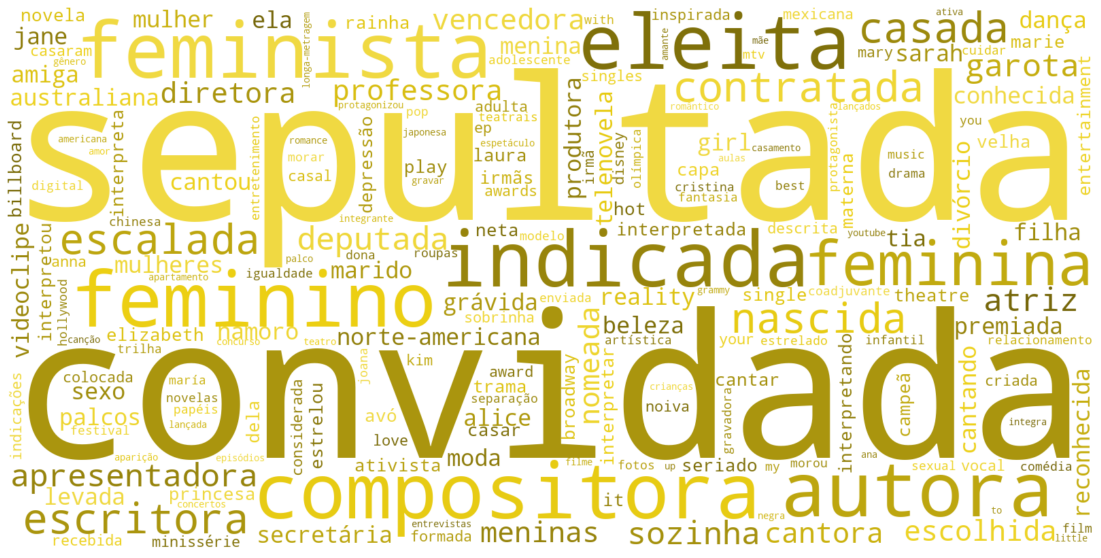

In [40]:
def yellow_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(52, 85%%, %d%%)" % random.randint(25, 60)

plt.figure( figsize=(20,10) )        
Cloud = WordCloud(background_color="white", width=1600, height=800).generate_from_frequencies(pmi_women)
plt.imshow(Cloud.recolor(color_func=yellow_color_func, random_state=3), interpolation="bilinear")
plt.axis("off")
plt.show()

### Palavras mais associadas a homens 

Já as palavras mais fortemente associadas ao gênero masculino são bem diferentes, a maioria delas relacionada a esportes, principalmente o futebol. Isso indica que a grande maioria dos artigos de homens na wikipedia são de esportes, mas também é um indicativo da diferença na maneira como mulheres e homens são retratados na wikipedia, visto que enquanto mulheres apresentam atributos de relacionamento homens apresentam mais atributos relacionados ao seu trabalho.

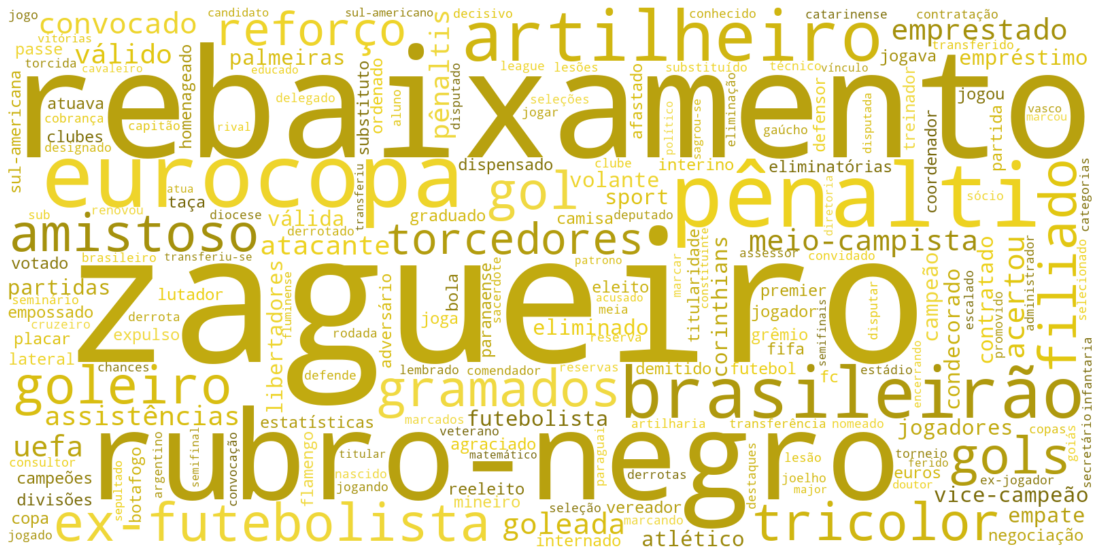

In [41]:
sorted_m = {k: v for k, v in sorted(pmi_men.items(), key=lambda item: item[1], reverse=True)}   
plt.figure( figsize=(20,10) )        
Cloud = WordCloud(background_color="white", width=1600, height=800).generate_from_frequencies(sorted_m)
plt.imshow(Cloud.recolor(color_func=yellow_color_func, random_state=3),interpolation="bilinear")
plt.axis("off")
plt.show()

### Análise dos eventos que aparecem nas biografias de cada gênero

Em um artigo (https://arxiv.org/abs/2106.01601) os autores analisaram os eventos que aparecem nas biografias da Wikipédia e perceberam que eventos relacionados a vida pessoal aparecem mais em biografias de mulheres. A análise feita por eles é mais complexa, eles usam um modelo de detecção de eventos. Como não encontrei esse artigo no início do projeto da disciplina, não foi possível fazer uma análise similar. Mas como eventos normalmente são verbos, decidi analisar, superficialmente, os verbos que mais aparecem nas biografias de mulheres e de homens.

In [42]:
male_verbs = []
female_verbs = []
for i, (n, tag) in enumerate(zip(names, tags)):
    if n['gender'] == 'male':
        for j, t in enumerate(tag):
            if 'v-' in t and texts[i][j] not in stopwords and t != 'v-inf':
                male_verbs.append(texts[i][j])
    if n['gender'] == 'female':
        for j, t in enumerate(tag):
            if 'v-' in t and texts[i][j] not in stopwords and t != 'v-inf':
                female_verbs.append(texts[i][j])

In [43]:
tf_male = dict(Counter(male_verbs))
tf_female = dict(Counter(female_verbs))

### Verbos que mais aparecem em biografias de mulheres

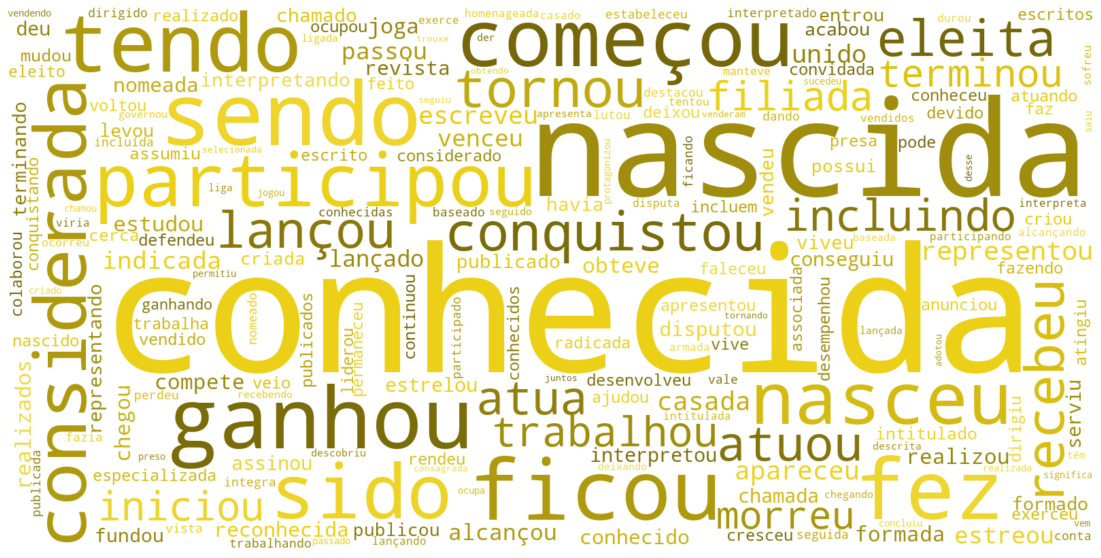

In [44]:
sorted_w = {k: v for k, v in sorted(tf_female.items(), key=lambda item: item[1], reverse=True)}   
plt.figure( figsize=(20,10) )        
Cloud = WordCloud(background_color="white", width=1600, height=800).generate_from_frequencies(sorted_w)
plt.imshow(Cloud.recolor(color_func=yellow_color_func, random_state=3),interpolation="bilinear")
plt.axis("off")
plt.show()

### Verbos que mais aparecem em biografias de homens

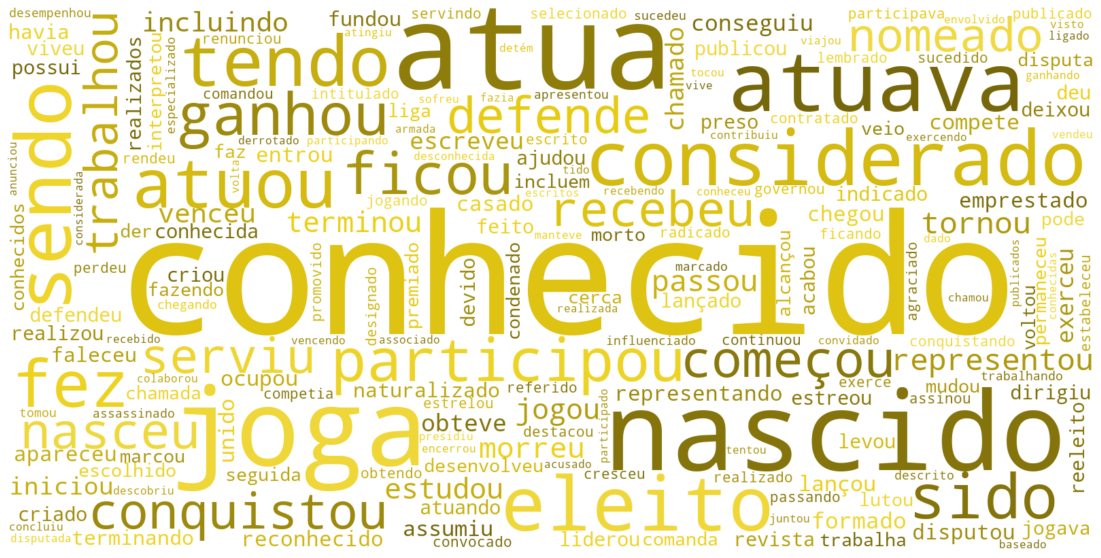

In [45]:
sorted_m = {k: v for k, v in sorted(tf_male.items(), key=lambda item: item[1], reverse=True)}   
plt.figure( figsize=(20,10) )        
Cloud = WordCloud(background_color="white", width=1600, height=800).generate_from_frequencies(sorted_m)
plt.imshow(Cloud.recolor(color_func=yellow_color_func, random_state=3),interpolation="bilinear")
plt.axis("off")
plt.show()

## 2.4. Avaliação de Modelos Word2Vec

Foi realizada uma avaliação intrínseca para os modelos de linguagem Word2Vec (CBOW e Skip-Gram), testando e reportando os resultados obtidos com a variação de um conjunto de hiperparamentros e utilizar analogias para então comparar a distância do cosseno entre a palavra esperada e o resultado da manipulação geométrica.

Foi utilizada a implementação dos modelos Word2Vec disponível na biblioteca Gensim, o corpus de inteiro biografias e os dados de analogia foram criados para tentar capturar possíveis associações entre os gêneros e diferentes profissões. 

In [46]:
def create_word2vec_model(sentences, vec_size, window_size, algorithm):
    model = gensim.models.Word2Vec(sentences=sentences, vector_size=vec_size, window=window_size, sg=algorithm, min_count=5)
    return model

def compute_similarity(model, analogies_file, output_path):
    with open(analogies_file, 'r') as f:
        data = f.readlines()
    analogies = [line.split() for line in data]
    df = []
    success = 0
    count_for_accuracy = 0
    for w0, w1, w2, w3 in analogies:
        
        # w0 w1 w2 w3 => homem mulher word_h word_m
        # w1 w0 w3 w2 => mulher homem word_m word_h
        try: 
            if w3 in model.wv:
                similarities = model.wv.most_similar(positive=[w1, w2], negative=[w0], topn=1) 
                cos_similarity = model.wv.similarity(similarities[0][0], w3)
                cos_distance = model.wv.distance(similarities[0][0], w3)
                df.append({'analogy': 'homem -> mulher','expected': w3, 'result': similarities[0][0], 'cos_similarity': cos_similarity, 'cos_distance': cos_distance})
                if w3 == similarities[0][0]:
                    success +=1
            if w2 in model.wv:
                similarities = model.wv.most_similar(positive=[w0, w3], negative=[w1], topn=1) 
                cos_similarity = model.wv.similarity(similarities[0][0], w2)
                cos_distance = model.wv.distance(similarities[0][0], w2)
                df.append({'analogy': 'mulher -> homem', 'expected': w2, 'result': similarities[0][0], 'cos_similarity': cos_similarity, 'cos_distance': cos_distance})
                if w2 == similarities[0][0]:
                    success +=1
        except:
            count_for_accuracy += 1
            pass
    
    pd.DataFrame(df).to_csv(output_path+".csv", index=False)
    accuracy = success/(2*len(analogies) - 2*(count_for_accuracy))
    return accuracy

Foram elaborados 24 modelos diferentes, variando os seguintes parâmetros para a função `gensim.model.Word2Vec`:
 
1. `vector_size`: Foi variada a dimensionalidade do vetor de palavras entre 100, 150 e 200.

2. `window`: Tamanho da janela que corresponde a máxima distância entre a palavra atual e a palavra predita na sentença, variando entre 4, 5, 6 e 7. Esse parâmetro é usado para limitar o número de palavras no contexto.

3. `sg`: Define qual algoritmo será usado para o treinamento do modelo: Skip-Gram (sg = 1) ou CBOW (sg = 0).


In [781]:
import time
start_time = time.time()
for window_size in [4, 5, 6, 7]:
    for vec_size in [100, 150, 200]: 
        for model_type in range(0, 2):  # 1 for skip-gram and 0 for cbow
            if model_type == 0:
                algo = "cbow"
            else:
                algo = "skip gram"
            output_path = "all_corpus-"+str(window_size)+"-"+str(vec_size)+"-"+str(model_type)
            model = create_word2vec_model(preprocessed_text, vec_size, window_size, model_type)
            acc = compute_similarity(model, "analogies.txt", output_path)
            print("Model: window size: {}, vector size: {}, algorithm: {}, accuracy: {:.3f}, time: {:.4f}".format(window_size, vec_size, algo, acc, time.time()-start_time))

Model: window size: 4, vector size: 100, algorithm: cbow, accuracy: 0.353, time: 40.8206
Model: window size: 4, vector size: 100, algorithm: skip gram, accuracy: 0.529, time: 158.0942
Model: window size: 4, vector size: 150, algorithm: cbow, accuracy: 0.402, time: 207.0213
Model: window size: 4, vector size: 150, algorithm: skip gram, accuracy: 0.578, time: 359.4721
Model: window size: 4, vector size: 200, algorithm: cbow, accuracy: 0.382, time: 409.2684
Model: window size: 4, vector size: 200, algorithm: skip gram, accuracy: 0.471, time: 577.1907
Model: window size: 5, vector size: 100, algorithm: cbow, accuracy: 0.373, time: 616.7436
Model: window size: 5, vector size: 100, algorithm: skip gram, accuracy: 0.520, time: 762.7068
Model: window size: 5, vector size: 150, algorithm: cbow, accuracy: 0.373, time: 816.3155
Model: window size: 5, vector size: 150, algorithm: skip gram, accuracy: 0.539, time: 1012.0549
Model: window size: 5, vector size: 200, algorithm: cbow, accuracy: 0.382, 

Podemos reparar acima que o melhor modelo foi o Skip-Gram com vector size de 150 e janela de tamanho 4. A seguir serão plotados os gráficos com a média das distâncias do cosseno e com a acurácia, subdivididos entre os dois tipos de algoritmo (CBOW e Skip-Gram).

In [47]:
def mean_cos_distance(df):
    return np.mean(df['cos_distance'])

def acertos(df):
    return len(df[df['cos_similarity'] >= 0.99])/len(df)*100

def expected_on_top10(df):
    return len(df[df['pos_rank'] <= 10])/len(df)*100

def plot_linhas(funcao, y_label):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    count = 0
    for alg in range(0, 2):
        for vec_size in range(100, 250, 50):
            y = []
            windows = [4, 5, 6, 7]
            for window_size in windows:
                df = pd.read_csv("all_corpus-"+str(window_size)+"-"+str(vec_size)+"-"+str(alg)+".csv")
                y.append(funcao(df))
                legend = 'vector size '+str(vec_size)
            ax[alg].plot(windows, y, label=legend)
            ax[alg].legend()
            if alg == 0:
                name_alg = "CBOW"
            else:
                name_alg = "Skip-Gram"
            ax[alg].set_title(name_alg, size=14)
            ax[alg].set_xlabel("Tamanho da janela", size=12) 
            ax[alg].set_ylabel(y_label, size=12)
            ax[alg].set_xticks(windows)
            
    fig.tight_layout()
    plt.show()

Podemos ver que os resultados obtidos pelo CBOW foram sempre piores que os do Skip-Gram. 

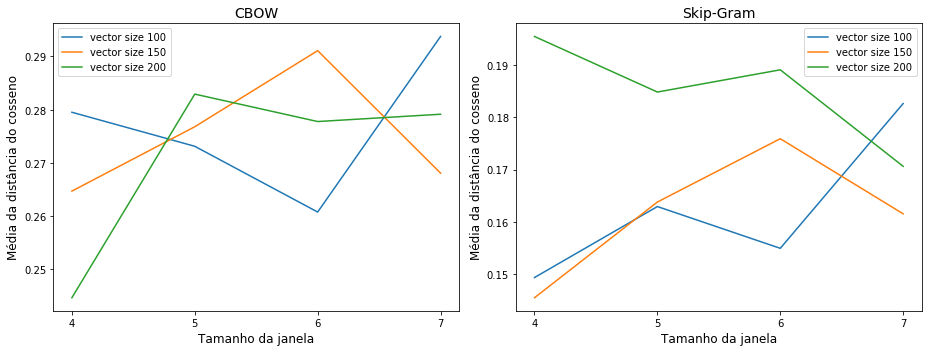

In [48]:
plot_linhas(mean_cos_distance, "Média da distância do cosseno")

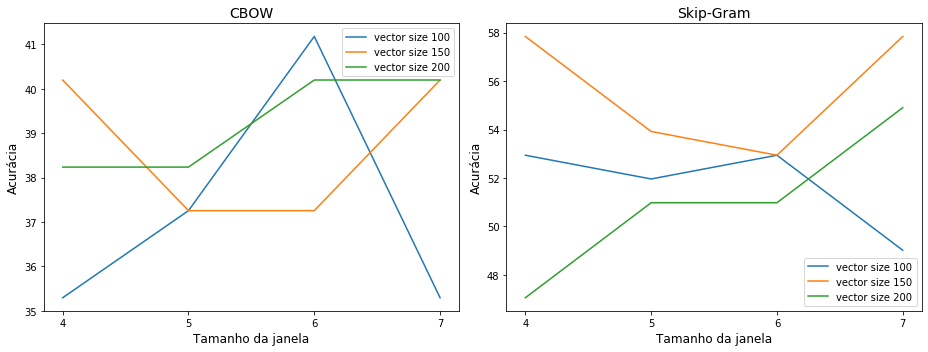

In [49]:
plot_linhas(acertos, "Acurácia")

Analisando os resultados para cada uma das analogias, foi possível perceber algumas relações estereotipadas, principalmente nos modelos treinados com CBOW. Um exemplo é a analogia:

    homem - mulher -> cirgião - cirurgiã 

Que retornou a profissão `enfermeira` ao invés de cirugiã. Outros exemplos foram citados na apresentação.

# 3. Conclusão

Nossos resultados indicam diferenças significativas sobre a forma como as mulheres são retratadas em comparação com os homens. Em particular, percebemos que os relacionamentos amorosos de mulheres são muito mais frequentemente considerados e discutidos nos artigos da Wikipédia do que os de homens. Entretanto, não é possível afirmar que toda a disparidade encontrada é atribuída a um viés presente na Wikipédia ou se é apenas um reflexo de vieses da sociedade. 

O foco em apenas um idioma é uma limitação deste trabalho, pois adicionamos às nossas análises o viés cultural dos países da língua estudada. Como 68% dos editores da Wikipédia em português são brasileiros, temos o viés da cultura brasileira bastante presente na base de dados. Uma outra limitação foi considerar apenas o binarismo de gênero, mas acreditamos que esse seja um primeiro passo para conseguir analisar a dimensão de gênero no conteúdo da Wikipédia a partir de uma perspectiva mais inclusiva. Por fim, a análise com os Word Embeddings pode ser aprimorada para tentar encontrar relações mais estereotipadas, testando para outras analogias também. Foram testadas analogias com palavras de relacionamento (como marido e esposa) mas nos testes realizados essas não apresentaram nenhum indício de viés. 